In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
# Debugging function for model
def debug_model(message, model):
    print(f"[DEBUG] {message}: {model.summary()}")

In [4]:
# Load preprocessed data
with open("/content/drive/MyDrive/Colab Notebooks/Project-1/Scalers/preprocessed_data.pkl", "rb") as f:
    preprocessed_data = pickle.load(f)

# Extract training and testing data
train_padded_scaled = preprocessed_data["train_padded_scaled"]
test_padded_scaled = preprocessed_data["test_padded_scaled"]
train_next_scaled = preprocessed_data["train_next_scaled"]
test_next_scaled = preprocessed_data["test_next_scaled"]
train_coeff_scaled = preprocessed_data["train_coeff_scaled"]
test_coeff_scaled = preprocessed_data["test_coeff_scaled"]
train_type_labels = preprocessed_data["train_type_labels"]
test_type_labels = preprocessed_data["test_type_labels"]
seq_scaler = preprocessed_data["seq_scaler"]
next_scaler = preprocessed_data["next_scaler"]
coeff_scaler = preprocessed_data["coeff_scaler"]

# Debugging shapes
print(f"[DEBUG] Train Padded Sequences Shape: {train_padded_scaled.shape}")
print(f"[DEBUG] Test Padded Sequences Shape: {test_padded_scaled.shape}")
print(f"[DEBUG] Train Next Values Shape: {train_next_scaled.shape}")
print(f"[DEBUG] Test Next Values Shape: {test_next_scaled.shape}")

[DEBUG] Train Padded Sequences Shape: (80000, 20)
[DEBUG] Test Padded Sequences Shape: (20000, 20)
[DEBUG] Train Next Values Shape: (80000, 1)
[DEBUG] Test Next Values Shape: (20000, 1)


# Next Value Prediction Model

In [ ]:
# Attention layer
class Attention(layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        return inputs * attention_weights

In [ ]:
# Build Improved BiLSTM Model with Attention
input_layer = layers.Input(shape=(train_padded_scaled.shape[1], 1))

# First BiLSTM Layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(input_layer)
x = layers.Dropout(0.3)(x)

# Second BiLSTM Layer
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(x)
x = layers.Dropout(0.3)(x)

# Attention Layer (Correct Implementation)
attn = layers.Attention()([x, x])
x = layers.Add()([x, attn])  # Residual Connection

# Flatten the attention output
x = layers.GlobalAveragePooling1D()(x)

# Dense Layers
x = layers.Dense(64, activation='swish')(x)
x = layers.Dense(32, activation='swish')(x)

# Output Layer
output_layer = layers.Dense(1)(x)

In [ ]:
# Compile Model
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Debug Model Architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 20, 256)        │        133,120 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 20, 256)        │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 20, 128)        │        164,352 │ dropout_4[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 20, 128)        │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 20, 128)        │              0 │ dropout_5[0][0],       │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 128)        │              0 │ dropout_5[0][0],       │
│                           │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ add[0][0]              │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             33 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 307,841 (1.17 MB)

 Trainable params: 307,841 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape Input for LSTM
train_padded_lstm = train_padded_scaled[..., np.newaxis]  # (batch_size, 20, 1)
test_padded_lstm = test_padded_scaled[..., np.newaxis]    # (batch_size, 20, 1)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the Model
history = model.fit(train_padded_lstm, train_next_scaled,
                    validation_data=(test_padded_lstm, test_next_scaled),
                    epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.3880 - val_loss: 0.0650
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0603 - val_loss: 0.0324
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0374 - val_loss: 0.0310
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0295 - val_loss: 0.0244
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0284 - val_loss: 0.0214
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0212 - val_loss: 0.0241
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0220 - val_loss: 0.0141
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0215 - val_loss: 0.0197
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0195 - val_loss: 0.0103
Epoch 10/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0151 - val_loss: 0.0093
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0211 - val_loss: 0.01

In [ ]:
# Predict and Evaluate Model
predictions = model.predict(test_padded_lstm).squeeze()
mse = mean_squared_error(test_next_scaled.reshape(-1), predictions)
print(f"Mean Squared Error: {mse}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Mean Squared Error: 0.004690670269661103


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Project-1/Models/next_value_prediction_model-3.keras")
print("Model saved successfully!")

Model saved successfully!


Mean Squared Error: 0.004690670269661103


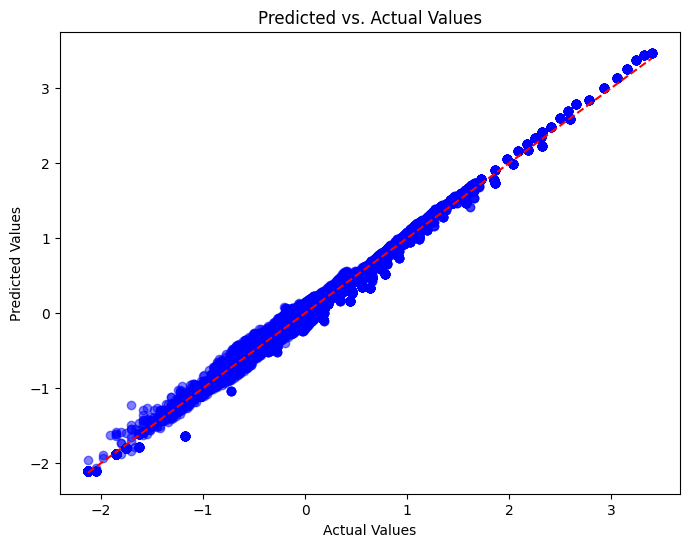

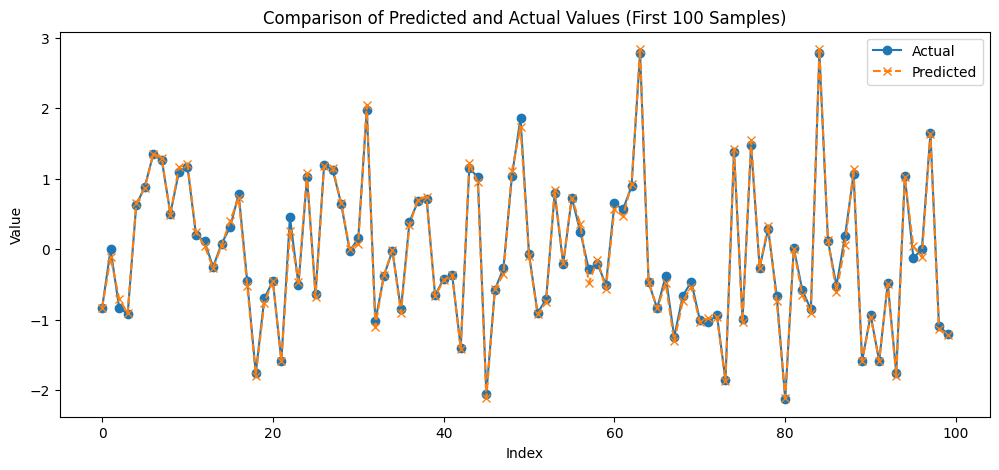

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Convert predictions to numpy array (if not already)
predictions = np.array(predictions).flatten()
actual_values = np.array(test_next_scaled).flatten()

# Compute Mean Squared Error
mse = mean_squared_error(actual_values, predictions)
print(f"Mean Squared Error: {mse}")

# 📊 Scatter Plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions, alpha=0.5, color="blue")
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()

# 📈 Line Plot: Comparison of Predictions and Actual Values
plt.figure(figsize=(12, 5))
plt.plot(actual_values[:100], label="Actual", marker="o", linestyle="-")
plt.plot(predictions[:100], label="Predicted", marker="x", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Predicted and Actual Values (First 100 Samples)")
plt.legend()
plt.show()


# Type Classification Prediction Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import pickle

In [ ]:
# Function to check if a number is prime
def is_prime(n):
    if n < 2:
        return 0
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return 0
    return 1

In [ ]:
# Generate prime flags for sequences
def generate_prime_flags(sequences):
    return [[is_prime(num) for num in seq] for seq in sequences]

# Compute the differences between consecutive elements
def generate_differences(sequences):
    return [[seq[i] - seq[i - 1] for i in range(1, len(seq))] + [0] for seq in sequences]

In [ ]:
# Generate new features
train_prime_flags = np.array(generate_prime_flags(train_padded_scaled))
test_prime_flags = np.array(generate_prime_flags(test_padded_scaled))

train_differences = np.array(generate_differences(train_padded_scaled))
test_differences = np.array(generate_differences(test_padded_scaled))

In [ ]:
# Expand dimensions to match LSTM input
train_padded_scaled = np.expand_dims(train_padded_scaled, axis=-1)
test_padded_scaled = np.expand_dims(test_padded_scaled, axis=-1)

train_prime_flags = np.expand_dims(train_prime_flags, axis=-1)
test_prime_flags = np.expand_dims(test_prime_flags, axis=-1)

train_differences = np.expand_dims(train_differences, axis=-1)
test_differences = np.expand_dims(test_differences, axis=-1)

# Concatenate all features along the last axis
train_features = np.concatenate([train_padded_scaled, train_prime_flags, train_differences], axis=-1)
test_features = np.concatenate([test_padded_scaled, test_prime_flags, test_differences], axis=-1)

In [ ]:
# Model Architecture
def build_classification_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # LSTM Layers with reduced L2 Regularization
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)))(inputs)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)))(x)
    x = layers.Dropout(0.3)(x)

    # Attention Mechanism After Final LSTM Layer
    attention = layers.Attention()([x, x])
    x = layers.GlobalAveragePooling1D()(attention)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Get input shape and number of classes
input_shape = train_features.shape[1:]  # (sequence_length, num_features)
num_classes = len(np.unique(train_type_labels))

In [ ]:
# Initialize the model
classification_model = build_classification_model(input_shape, num_classes)

# Compile the model with an optimized learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
classification_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Debugging model architecture
classification_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 20, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 20, 256)        │        135,168 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_46 (Dropout)      │ (None, 20, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 20, 128)        │        164,352 │ dropout_46[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_47 (Dropout)      │ (None, 20, 128)        │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 20, 128)        │              0 │ dropout_47[0][0],      │
│                           │                        │                │ dropout_47[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 128)            │         16,512 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_48 (Dropout)      │ (None, 128)            │              0 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 64)             │          8,256 │ dropout_48[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 64)             │              0 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 5)              │            325 │ dropout_49[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 325,125 (1.24 MB)

 Trainable params: 324,869 (1.24 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Train the model
classification_history = classification_model.fit(
    train_features, train_type_labels,
    validation_data=(test_features, test_type_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.7102 - loss: 1.0923 - val_accuracy: 0.7538 - val_loss: 0.6118 - learning_rate: 5.0000e-04
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.8539 - loss: 0.3994 - val_accuracy: 0.7554 - val_loss: 0.7869 - learning_rate: 5.0000e-04
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.8917 - loss: 0.3161 - val_accuracy: 0.9253 - val_loss: 0.2524 - learning_rate: 5.0000e-04
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9201 - loss: 0.2622 - val_accuracy: 0.7487 - val_loss: 1.8116 - learning_rate: 5.0000e-04
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9293 - loss: 0.2429 - val_accuracy: 0.9693 - val_loss: 0.1529 - learning_rate: 5.0000e-04
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9433 - loss: 0.2042 - val_accuracy: 0.9726 - val_loss: 0.1245 - learning_rate: 5.0000e-04
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model
test_accuracy = classification_model.evaluate(test_features, test_type_labels)[1]
print(f"\nTest Accuracy: {test_accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9980 - loss: 0.0225

Test Accuracy: 0.9980000257492065


In [ ]:
# Save the improved model
classification_model.save("/content/drive/MyDrive/Colab Notebooks/Project-1/Models/sequence_classification_model-1.keras")
print("classification model saved successfully!")

classification model saved successfully!


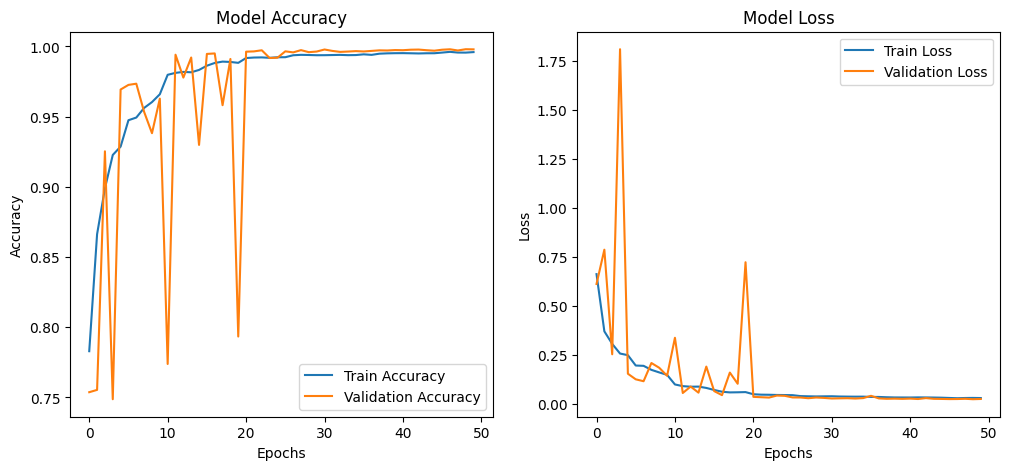

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(classification_history.history['accuracy'], label='Train Accuracy')
plt.plot(classification_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(classification_history.history['loss'], label='Train Loss')
plt.plot(classification_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Coefficients Prediction Model

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [6]:
# 🔹 Load preprocessed data
with open("/content/drive/MyDrive/Colab Notebooks/Project-1/Scalers/preprocessed_data.pkl", "rb") as f:
    preprocessed_data = pickle.load(f)

# 🔹 Extract Training Data
train_sequences = np.expand_dims(preprocessed_data["train_padded_scaled"], axis=-1)
test_sequences = np.expand_dims(preprocessed_data["test_padded_scaled"], axis=-1)
train_coefficients = np.array(preprocessed_data["train_coeff_scaled"], dtype=np.float32)
test_coefficients = np.array(preprocessed_data["test_coeff_scaled"], dtype=np.float32)

In [7]:
# 🔹 Model Architecture
def build_coefficient_model(input_shape, output_dim):
    inputs = layers.Input(shape=input_shape)

    # Feature Extraction with CNN
    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # LSTM Layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    # Attention Mechanism
    attention = layers.Attention()([x, x])
    x = layers.GlobalAveragePooling1D()(attention)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(output_dim, activation="linear")(x)

    model = models.Model(inputs, outputs)
    return model

In [8]:
# 🔹 Define Model Parameters
input_shape = train_sequences.shape[1:]
output_dim = train_coefficients.shape[1]

In [9]:
# 🔹 Initialize Model
model = build_coefficient_model(input_shape, output_dim)

# 🔹 Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics=["mae"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 64)         │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 20, 128)        │         24,704 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 20, 128)        │            512 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 20, 256)        │        263,168 │ batch_normalization[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 20, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 20, 128)        │        164,352 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 128)        │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 20, 128)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            260 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 478,020 (1.82 MB)

 Trainable params: 477,764 (1.82 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
# 🔹 Training Callbacks
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [11]:
# 🔹 Train Model
history = model.fit(
    train_sequences, train_coefficients,
    validation_data=(test_sequences, test_coefficients),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0188 - mae: 0.0896 - val_loss: 0.0064 - val_mae: 0.0537 - learning_rate: 0.0010
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0051 - mae: 0.0448 - val_loss: 0.0031 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0034 - mae: 0.0354 - val_loss: 0.0015 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0029 - mae: 0.0320 - val_loss: 0.0013 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0030 - mae: 0.0319 - val_loss: 0.0015 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 0.0027 - mae: 0.0302 - val_loss: 0.0015 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0024 - mae: 0.0287 - val_loss: 9.5176e-04 - val_mae: 0.017

In [12]:
# 🔹 Evaluate Model
predictions = model.predict(test_sequences)

mse = mean_squared_error(test_coefficients, predictions)
r2 = r2_score(test_coefficients, predictions)

print(f"\n🔹 Model Evaluation:\nMSE: {mse:.4f}\nR² Score: {r2:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

🔹 Model Evaluation:
MSE: 0.0005
R² Score: 0.9879


In [13]:
# 🔹 Save Model
model.save("/content/drive/MyDrive/Colab Notebooks/Project-1/Models/coefficient_prediction_model-2.keras")
print("Model training complete and saved!")

Model training complete and saved!


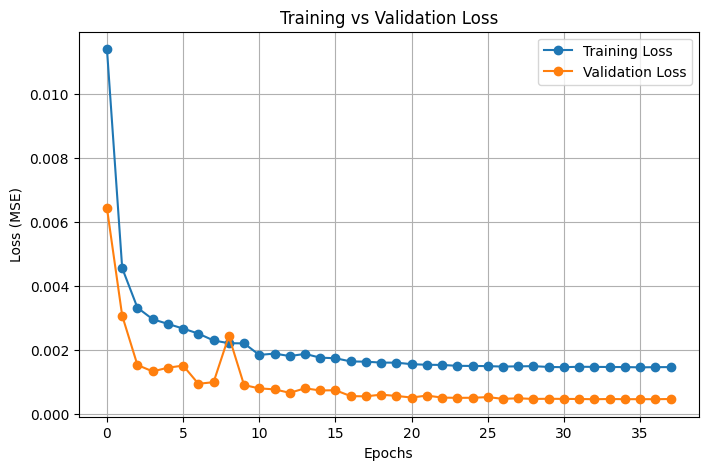

In [14]:
import matplotlib.pyplot as plt

# 🔹 Extract loss & validation loss from history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# 🔹 Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

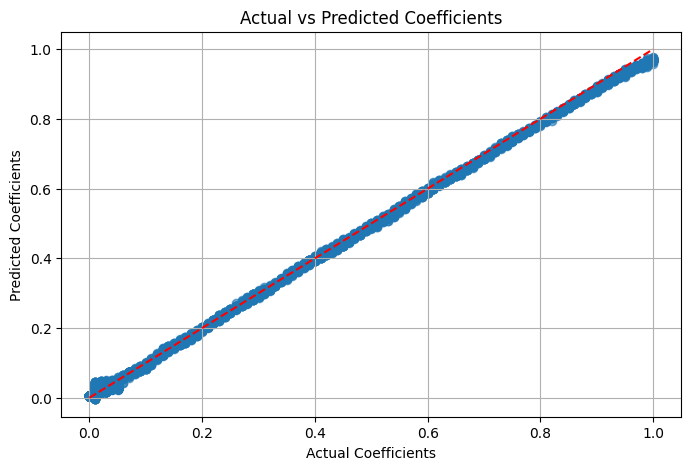

In [15]:
import numpy as np

# 🔹 Get first coefficient (or modify for specific ones)
actual_coeffs = test_coefficients[:, 0]
predicted_coeffs = predictions[:, 0]

# 🔹 Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(actual_coeffs, predicted_coeffs, alpha=0.6)
plt.plot([min(actual_coeffs), max(actual_coeffs)], [min(actual_coeffs), max(actual_coeffs)], "r--")  # Perfect Prediction Line
plt.xlabel("Actual Coefficients")
plt.ylabel("Predicted Coefficients")
plt.title("Actual vs Predicted Coefficients")
plt.grid(True)
plt.show()

# Next Value Prediction

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [46]:
# 🔹 **Load Preprocessed Data**
with open("/content/drive/MyDrive/Colab Notebooks/Project-1/Scalers/preprocessed_data.pkl", "rb") as f:
    preprocessed_data = pickle.load(f)

train_sequences = np.expand_dims(preprocessed_data["train_padded_scaled"], axis=-1)
test_sequences = np.expand_dims(preprocessed_data["test_padded_scaled"], axis=-1)

train_next_scaled = np.array(preprocessed_data["train_next_scaled"], dtype=np.float32)
test_next_scaled = np.array(preprocessed_data["test_next_scaled"], dtype=np.float32)

seq_scaler = preprocessed_data["seq_scaler"]
next_scaler = preprocessed_data["next_scaler"]

In [49]:
# 🔹 **Define the Model with Attention & Residual Connections**
def build_next_value_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # First LSTM layer with residual connection
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
    x = layers.LayerNormalization()(x)  # Normalize activations
    x_res = layers.Dropout(0.3)(x) # Assign to x_res for the residual connection

    # Second LSTM layer
    x2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x_res)
    x2 = layers.LayerNormalization()(x2)  # Normalize activations
    x2 = layers.Dropout(0.3)(x2)

    # 🔹 **Attention Mechanism**
    attention = layers.Attention()([x2, x2])

    # Project the attention output to match x_res shape
    attention = layers.Dense(x_res.shape[-1], activation='linear')(attention)

    x = layers.Add()([x_res, attention])  # Residual connection with x_res
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="linear")(x)  # Predict single next value

    model = models.Model(inputs, outputs)
    return model

In [50]:
# 🔹 **Initialize Model**
input_shape = train_sequences.shape[1:]  # (sequence_length, 1)
model = build_next_value_model(input_shape)

In [54]:
# 🔹 **Compile the Model**
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="huber",  # Changed from 'huber_loss' to 'huber'
              metrics=["mae"])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_13          │ (None, 20, 256)        │        133,120 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 20, 256)        │            512 │ bidirectional_13[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 20, 256)        │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_14          │ (None, 20, 128)        │        164,352 │ dropout_21[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 20, 128)        │            256 │ bidirectional_14[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 20, 128)        │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_6 (Attention)   │ (None, 20, 128)        │              0 │ dropout_22[0][0],      │
│                           │                        │                │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 20, 256)        │         33,024 │ attention_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 256)        │              0 │ dropout_21[0][0],      │
│                           │                        │                │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 64)             │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             65 │ dropout_23[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 347,777 (1.33 MB)

 Trainable params: 347,777 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# 🔹 **Set Up Callbacks**
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [56]:
# 🔹 **Train the Model**
history = model.fit(
    train_sequences, train_next_scaled,
    validation_data=(test_sequences, test_next_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - loss: 0.1162 - mae: 0.3449 - val_loss: 0.0063 - val_mae: 0.0823 - learning_rate: 0.0010
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.0248 - mae: 0.1630 - val_loss: 0.0060 - val_mae: 0.0860 - learning_rate: 0.0010
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - loss: 0.0211 - mae: 0.1498 - val_loss: 0.0074 - val_mae: 0.0981 - learning_rate: 0.0010
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0178 - mae: 0.1363 - val_loss: 0.0048 - val_mae: 0.0755 - learning_rate: 0.0010
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0158 - mae: 0.1279 - val_loss: 0.0033 - val_mae: 0.0619 - learning_rate: 0.0010
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0148 - mae: 0.1224 - val_loss: 0.0027 - val_mae: 0.0566 - learning_rate: 0.0010
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0139 - mae: 0.1195 - val_loss: 0.0037 - val_mae: 0.0585 - 

In [57]:
# Predict on test set
predictions_scaled = model.predict(test_padded_scaled)

# Inverse transform predictions to original scale
predictions = next_scaler.inverse_transform(predictions_scaled)
test_actual = next_scaler.inverse_transform(test_next_scaled)

# Calculate MSE & R² Score
mse = mean_squared_error(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print(f"\nModel Evaluation:\nMSE: {mse:.4f}\nR² Score: {r2:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Model Evaluation:
MSE: 0.0015
R² Score: 0.9993


In [58]:
next_value_model.save("/content/drive/MyDrive/Colab Notebooks/Project-1/Models/next_value_prediction_model-5.keras")
print("Model training complete and saved!")

Model training complete and saved!


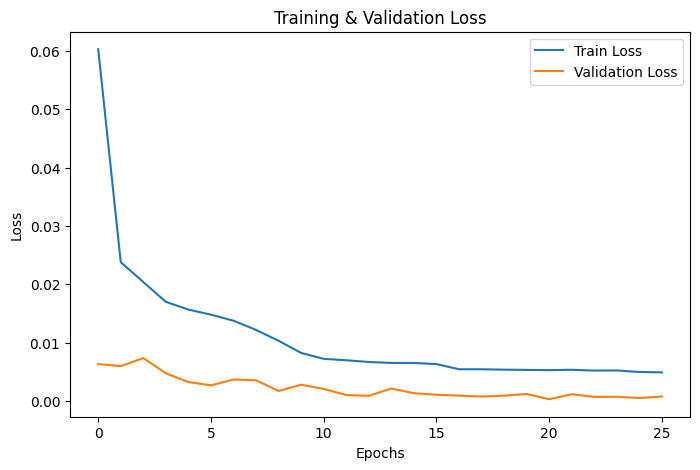

In [59]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

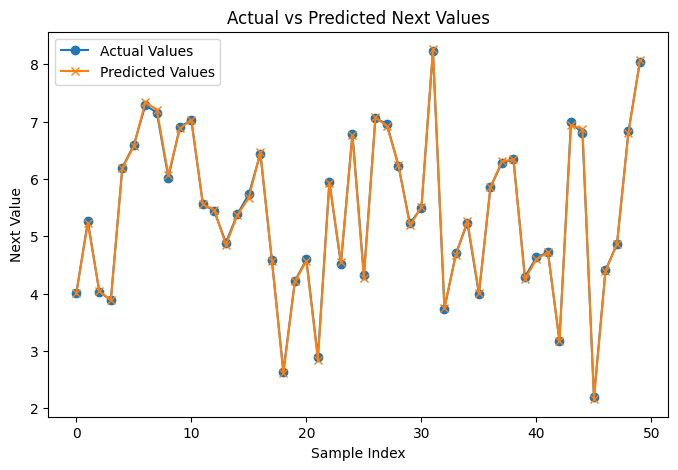

In [60]:
# Actual vs Predicted Values
plt.figure(figsize=(8,5))
plt.plot(test_actual[:50], label="Actual Values", marker="o")
plt.plot(predictions[:50], label="Predicted Values", marker="x")
plt.xlabel("Sample Index")
plt.ylabel("Next Value")
plt.legend()
plt.title("Actual vs Predicted Next Values")
plt.show()